# Toxic comments 🤬

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

**Цель проекта:** Обучить модель классифицировать комментарии на позитивные и негативные.

**Содержание**<a id='toc0_'></a>    
1. [ Подготовка  ](#toc1_)    
1.1. [Библиотеки  ](#toc1_1_)    
1.2. [Конфигурация  ](#toc1_2_)    
1.3. [Сервисные функции  ](#toc1_3_)    
2. [Данные  ](#toc2_)    
2.1. [Загрузка  ](#toc2_1_)    
2.2. [Проверка типов данных  ](#toc2_2_)    
2.3. [Проверка пропусков  ](#toc2_3_)    
2.4. [Проверка полных дубликатов  ](#toc2_4_)    
2.5. [Изучение таргета  ](#toc2_5_)    
2.6. [Выводы по датасету  ](#toc2_6_)    
3. [Обработка текста  ](#toc3_)    
4. [Модели  ](#toc4_)    
4.1. [Разделение данных  ](#toc4_1_)    
4.2. [Подготовка ](#toc4_2_)    
4.3. [Модель `LogisticRegression` ](#toc4_3_)    
4.4. [Модель `RandomForestClassifier`](#toc4_4_)    
4.5. [Модель `LGBMClassifier`](#toc4_5_)    
4.6. [Модель `CatBoostClassifier`](#toc4_6_)    
5. [Результаты](#toc5_)    
5.1. [Результаты на тренировочной выборке](#toc5_1_)    
5.2. [Результаты на тестовой выборке](#toc5_2_)    
6. [Общий вывод](#toc6_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=true
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## 1. <a id='toc1_'></a> Подготовка   [&#8593;](#toc0_)

### 1.1. <a id='toc1_1_'></a>Библиотеки   [&#8593;](#toc0_)

In [1]:
from IPython.display import clear_output

In [2]:
%pip install -q matplotlib==3.8.4
%pip install -q numpy==1.26.4
%pip install -q pandas==2.2.3
%pip install -q prettytable==3.12.0
%pip install -q scikit-learn==1.5.2
%pip install -q termcolor==2.5.0

clear_output()

In [ ]:
import re
from os.path import exists


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from prettytable import PrettyTable
from termcolor import colored
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import (train_test_split,
                                     StratifiedKFold,
                                     cross_val_score)
from sklearn.metrics import (f1_score,
                             classification_report,
                             ConfusionMatrixDisplay)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from hyperopt import (hp,
                      fmin,
                      tpe,
                      Trials,
                      STATUS_OK,
                      STATUS_FAIL)

In [4]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

clear_output()

### 1.2. <a id='toc1_2_'></a>Конфигурация   [&#8593;](#toc0_)

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
RANDOM_STATE = 27
TEST_SIZE = 0.2

### 1.3. <a id='toc1_3_'></a>Сервисные функции   [&#8593;](#toc0_)

In [7]:
def get_dataframe(paths: list[str], **kwargs) -> pd.DataFrame:
    for _path in paths:
        if not exists(_path) and not _path.startswith('http'):
            continue

        try:
            df = pd.read_csv(_path, **kwargs)
        except:
            continue

        if df is None:
            continue

        return df

    raise FileNotFoundError('No paths are valid for correct csv file.')

In [8]:
def check_duplicates(df: pd.DataFrame) -> None:
    duplicates_count = df.duplicated().sum()

    if duplicates_count == 0:
        print(colored('Полных дубликатов не обнаружено.', 'green'))
        return

    duplicates_part = duplicates_count / len(df)
    print(colored(f'Обнаружено {duplicates_count} дубликатов ({duplicates_part:.2%})', 'red'))

In [9]:
def check_nans(df: pd.DataFrame) -> None:
    if df.isna().sum().sum() == 0:
        print(colored('Полных дубликатов не обнаружено.', 'green'))
        return

    table = PrettyTable()
    table.field_names = ['Feature', 'Missing values count']

    missing_info = df.isna().sum().sort_values()
    cols = missing_info.index.to_list()
    for col in cols:
        count = missing_info[col]
        color = 'green' if count == 0 else 'red'
        s = f'{count} ({count / len(df):.2%})'
        table.add_row([col, colored(s, color)])

    print(table)

In [10]:
def get_value_counts(series: pd.Series) -> None:
    data = pd.DataFrame()
    data['count'] = series.value_counts()
    data['part'] = round(data['count'] / len(series), 4)
    display(data)

## 2. <a id='toc2_'></a>Данные   [&#8593;](#toc0_)

### 2.1. <a id='toc2_1_'></a>Загрузка   [&#8593;](#toc0_)

In [11]:
df = get_dataframe([
    './data/toxic_comments.csv',
    'datasets/toxic_comments.csv'
], index_col=0)

In [12]:
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


### 2.2. <a id='toc2_2_'></a>Проверка типов данных   [&#8593;](#toc0_)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


Все типы данных корректны.

### 2.3. <a id='toc2_3_'></a>Проверка пропусков   [&#8593;](#toc0_)

In [14]:
check_nans(df)

Полных дубликатов не обнаружено.


### 2.4. <a id='toc2_4_'></a>Проверка полных дубликатов   [&#8593;](#toc0_)

In [15]:
check_duplicates(df)

Полных дубликатов не обнаружено.


### 2.5. <a id='toc2_5_'></a>Изучение таргета   [&#8593;](#toc0_)

In [16]:
get_value_counts(df['toxic'])

,count,part
toxic,,
0,143106,0.8984
1,16186,0.1016


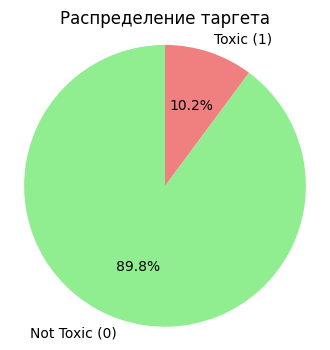

In [17]:
toxic_counts = df['toxic'].value_counts()

plt.figure(figsize=(4, 4))
plt.pie(toxic_counts,
        labels=['Not Toxic (0)', 'Toxic (1)'],
        colors=['lightgreen', 'lightcoral'],
        autopct='%1.1f%%',
        startangle=90)
plt.axis('equal')
plt.title('Распределение таргета')
plt.show()

Видим довольно большой дизбаланс.

### 2.6. <a id='toc2_6_'></a>Выводы по датасету   [&#8593;](#toc0_)

Перед нами датасет о комментариях с оценкой их токсичности. Пропуски не обнаружены. Полные дубликаты также не обнаружены. Распределение целевого признака крайне несбалансированное. Записей с таргетом `0` (not toxic) почти в 9 раз больше.

## 3. <a id='toc3_'></a>Обработка текста   [&#8593;](#toc0_)

In [18]:
lemmatizer = WordNetLemmatizer()
stop_words = stopwords.words('english')

In [19]:
def clean_text(text: str) -> str:
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = text.lower()

    return text

In [20]:
def preprocess_text(text: str) -> str:
    cleaned_text = clean_text(text)
    tokens = nltk.word_tokenize(cleaned_text)
    lemmas = [lemmatizer.lemmatize(token) for token in tokens if token.isalpha() and token not in stop_words]

    return ' '.join(lemmas)

In [21]:
df['text'] = df['text'].apply(preprocess_text)

In [22]:
df.head()

,text,toxic
0,explanation edits made username hardcore metal...,0
1,aww match background colour seemingly stuck th...,0
2,hey man really trying edit war guy constantly ...,0
3,make real suggestion improvement wondered sect...,0
4,sir hero chance remember page,0


## 4. <a id='toc4_'></a>Модели   [&#8593;](#toc0_)

### 4.1. <a id='toc4_1_'></a>Разделение данных   [&#8593;](#toc0_)

In [23]:
X = df['text']
y = df['toxic']

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=TEST_SIZE,
                                                    random_state=RANDOM_STATE,
                                                    stratify=y)

In [25]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(127433,) (31859,)
(127433,) (31859,)


### 4.2. <a id='toc4_2_'></a>Подготовка  [&#8593;](#toc0_)

In [26]:

def get_objective(estimator,
                  X_train: pd.DataFrame,
                  y_train: pd.Series):
    def objective(params: dict) -> float:
        """Кросс-валидация с текущими гиперпараметрами.

        Args:
            estimator: пайплайн с моделью или отдельно модель
            params (dict): гиперпараметры
            X_train (pd.DataFrame): входные признаки (features)
            y_train (pd.Series): целевой признак (target)

        Returns:
            dict: Словарь со средним значением метрики, гиперпараметрами и статусом.
        """
        # Некоторые параметры могут быть только целочисленные, приводим их к нужному типу
        for key, value in params.items():
            if isinstance(value, float) and value % 1 == 0:
                params[key] = int(value)

        estimator.set_params(**params)
        skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

        try:
            score = cross_val_score(estimator=estimator,
                                    X=X_train,
                                    y=y_train,
                                    scoring='f1',
                                    cv=skf,
                                    n_jobs=-1)

            return {
                'loss': -score.mean(),
                'params': params,
                'status': STATUS_OK
            }
        except:
            return {'status': STATUS_FAIL}

    return objective

In [ ]:
def get_model_results(estimator,
                      param_space: dict,
                      X_train: pd.DataFrame,
                      y_train: pd.Series,
                      max_evals: int = 1000
                      ) -> tuple[dict, float]:
    objective = get_objective(estimator, X_train, y_train)
    trials = Trials()

    fmin(
        fn=objective,
        space=param_space,
        algo=tpe.suggest,
        max_evals=max_evals,
        trials=trials,
        rstate=np.random.default_rng(RANDOM_STATE),
        show_progressbar=True
    )

    clear_output()

    best_params = trials.best_trial['result']['params']
    best_score = abs(trials.best_trial['result']['loss'])
    print(f'Finish with best F1 = {best_score:.4f}')

    return best_params, best_score

### 4.3. <a id='toc4_3_'></a>Модель `LogisticRegression`  [&#8593;](#toc0_)

In [28]:
lr_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_words)),
    ('model', LogisticRegression(random_state=RANDOM_STATE, n_jobs=-1))
])

In [29]:

param_space = {
    'tfidf__max_df':       hp.uniform('tfidf__max_df', 0.7, 1.0),                      # Максимальная частота слов в документах
    'tfidf__min_df':       hp.uniform('tfidf__min_df', 0.0, 0.3),                      # Минимальная частота слов в документах
    'tfidf__ngram_range':  hp.choice('tfidf__ngram_range', [(1, 1), (1, 2), (1, 3)]),  # Диапазон n-грамм
    'tfidf__max_features': hp.quniform('tfidf__max_features', 1000, 10000, 100),       # Максимальное количество признаков (целые числа)

    'model__C':            hp.loguniform('model__C', -5, 2),                           # Обратная сила регуляризации (log-scale)
    'model__penalty':      hp.choice('model__penalty', ['l2', 'l1']),                  # Тип регуляризации (L2 или L1)
    'model__solver':       hp.choice('model__solver', ['liblinear', 'saga']),          # Алгоритм оптимизации
    'model__class_weight': hp.choice('model__class_weight', [None, 'balanced']),       # Вес классов (автоматический баланс или нет)
    'model__max_iter':     hp.quniform('model__max_iter', 100, 1000, 100)              # Максимальное количество итераций (целые числа)
}

In [ ]:
# best_params_lr, best_score_lr = get_model_results(lr_pipeline, param_space, X_train, y_train, 100)

Finish with best F1 = 0.68


In [ ]:
best_params_lr

In [ ]:
best_score_lr

### 4.4. <a id='toc4_4_'></a>Модель `RandomForestClassifier` [&#8593;](#toc0_)

In [31]:
rfc_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_words)),
    ('model', RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1))
])

In [32]:
param_space = {
    'tfidf__max_features':       hp.choice('tfidf__max_features', [None, 1000, 5000, 10000]),       # Максимальное число признаков
    'tfidf__ngram_range':        hp.choice('tfidf__ngram_range', [(1, 1), (1, 2), (1, 3)]),         # Диапазон n-грамм для извлечения
    'tfidf__min_df':             hp.choice('tfidf__min_df', [1, 2, 5, 10]),                         # Минимальная частота слов в документах
    'tfidf__max_df':             hp.uniform('tfidf__max_df', 0.7, 1.0),                             # Максимальная частота слов в документах
    'tfidf__use_idf':            hp.choice('tfidf__use_idf', [True, False]),                        # Использовать обратную частоту документа
    'tfidf__smooth_idf':         hp.choice('tfidf__smooth_idf', [True, False]),                     # Сглаживать IDF веса
    'tfidf__sublinear_tf':       hp.choice('tfidf__sublinear_tf', [True, False]),                   # Применять сублинейное масштабирование TF

    'model__n_estimators':       hp.choice('model__n_estimators', [50, 100, 200, 500]),             # Количество деревьев в лесу
    'model__criterion':          hp.choice('model__criterion', ['gini', 'entropy']),                # Критерий качества разбиения
    'model__max_depth':          hp.choice('model__max_depth', [None, 10, 20, 30, 50]),             # Максимальная глубина дерева
    'model__min_samples_split':  hp.choice('model__min_samples_split', [2, 5, 10]),                 # Минимальное число объектов для разбиения
    'model__min_samples_leaf':   hp.choice('model__min_samples_leaf', [1, 2, 4]),                   # Минимальное число объектов в листе
    'model__bootstrap':          hp.choice('model__bootstrap', [True, False]),                      # Использовать бутстрэп выборки
    'model__class_weight':       hp.choice('model__class_weight', [None, 'balanced']),              # Веса классов для несбалансированных данных
}

In [ ]:
# best_params_rfc, best_score_rfc = get_model_results(rfc_pipeline, param_space, X_train, y_train, 100)

Finish with best F1 = 0.76


In [ ]:
best_params_rfc = {
    'model__bootstrap': False,
    'model__class_weight': None,
    'model__criterion': 'gini',
    'model__max_depth': None,
    'model__min_samples_leaf': 1,
    'model__min_samples_split': 10,
    'model__n_estimators': 500,
    'tfidf__max_df': 0.8416531114093017,
    'tfidf__max_features': 10000,
    'tfidf__min_df': 10,
    'tfidf__ngram_range': (1, 1),
    'tfidf__smooth_idf': True,
    'tfidf__sublinear_tf': False,
    'tfidf__use_idf': True
}

{'model__bootstrap': False,
 'model__class_weight': None,
 'model__criterion': 'gini',
 'model__max_depth': None,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 10,
 'model__n_estimators': 500,
 'tfidf__max_df': 0.8416531114093017,
 'tfidf__max_features': 10000,
 'tfidf__min_df': 10,
 'tfidf__ngram_range': (1, 1),
 'tfidf__smooth_idf': True,
 'tfidf__sublinear_tf': False,
 'tfidf__use_idf': True}

In [ ]:
best_score_rfc = 0.7556111272907714

0.7556111272907714

### 4.5. <a id='toc4_5_'></a>Модель `LGBMClassifier` [&#8593;](#toc0_)

In [34]:
lgbmc_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_words)),
    ('model', LGBMClassifier(random_state=RANDOM_STATE, n_jobs=-1, verbose=-1))
])

In [ ]:
param_space = {
    'tfidf__max_features':       hp.choice('tfidf__max_features', [None, 1000, 5000, 10000]),    # Максимальное количество слов в словаре
    'tfidf__ngram_range':        hp.choice('tfidf__ngram_range', [(1, 1), (1, 2), (1, 3)]),      # Диапазон n-грамм для анализа
    'tfidf__min_df':             hp.choice('tfidf__min_df', [1, 2, 5]),                          # Минимальная частота слова в документах
    'tfidf__max_df':             hp.uniform('tfidf__max_df', 0.7, 1.0),                          # Максимальная доля документов, содержащих слово
    'tfidf__use_idf':            hp.choice('tfidf__use_idf', [True, False]),                     # Использовать ли IDF
    'tfidf__smooth_idf':         hp.choice('tfidf__smooth_idf', [True, False]),                  # Сглаживать ли IDF
    'tfidf__sublinear_tf':       hp.choice('tfidf__sublinear_tf', [True, False]),                # Применять ли логарифмическое преобразование TF

    'model__boosting_type':      hp.choice('model__boosting_type', ['gbdt', 'dart', 'goss']),    # Тип бустинга
    'model__num_leaves':         hp.quniform('model__num_leaves', 10, 200, 1),                   # Количество листьев в дереве
    'model__learning_rate':      hp.loguniform('model__learning_rate', -5, 0),                   # Скорость обучения
    'model__n_estimators':       hp.quniform('model__n_estimators', 50, 500, 1),                 # Количество деревьев
    'model__subsample':          hp.uniform('model__subsample', 0.5, 1.0),                       # Доля выборки для обучения каждого дерева
    'model__colsample_bytree':   hp.uniform('model__colsample_bytree', 0.5, 1.0),                # Доля признаков для каждого дерева
    'model__reg_alpha':          hp.loguniform('model__reg_alpha', -5, 2),                       # L1-регуляризация
    'model__reg_lambda':         hp.loguniform('model__reg_lambda', -5, 2),                      # L2-регуляризация
    'model__min_child_samples':  hp.quniform('model__min_child_samples', 5, 100, 1),             # Минимальное количество объектов в листе
    'model__max_depth':          hp.choice('model__max_depth', [-1, 3, 5, 7, 10]),               # Максимальная глубина дерева (-1 = без ограничений)
}

In [36]:
best_params_lgbmc, best_score_lgbmc = get_model_results(lgbmc_pipeline, param_space, X_train, y_train, 100)

Finish with best F1 = 0.77


In [ ]:
best_params_lgbmc = {
    'model__boosting_type': 'gbdt',
    'model__colsample_bytree': 0.9998180861055651,
    'model__learning_rate': 0.04363398114359794,
    'model__max_depth': -1,
    'model__min_child_samples': 9,
    'model__n_estimators': 408,
    'model__num_leaves': 107,
    'model__reg_alpha': 0.0369531519316931,
    'model__reg_lambda': 0.19369702791386537,
    'model__subsample': 0.5376722197432499,
    'tfidf__max_df': 0.9488532999515908,
    'tfidf__max_features': None,
    'tfidf__min_df': 2,
    'tfidf__ngram_range': (1, 2),
    'tfidf__smooth_idf': True,
    'tfidf__sublinear_tf': False,
    'tfidf__use_idf': False
}

{'model__boosting_type': 'gbdt',
 'model__colsample_bytree': 0.9998180861055651,
 'model__learning_rate': 0.04363398114359794,
 'model__max_depth': -1,
 'model__min_child_samples': 9,
 'model__n_estimators': 408,
 'model__num_leaves': 107,
 'model__reg_alpha': 0.0369531519316931,
 'model__reg_lambda': 0.19369702791386537,
 'model__subsample': 0.5376722197432499,
 'tfidf__max_df': 0.9488532999515908,
 'tfidf__max_features': None,
 'tfidf__min_df': 2,
 'tfidf__ngram_range': (1, 2),
 'tfidf__smooth_idf': True,
 'tfidf__sublinear_tf': False,
 'tfidf__use_idf': False}

In [ ]:
best_score_lgbmc = 0.773983000615775

0.773983000615775

### 4.6. <a id='toc4_6_'></a>Модель `CatBoostClassifier` [&#8593;](#toc0_)

In [37]:
cbc = CatBoostClassifier(random_state=RANDOM_STATE, thread_count=-1, silent=True, text_features=[0])

In [38]:
param_space = {
    'model__n_estimators':       hp.choice('model__n_estimators', [50, 100, 200, 300]),  # Количество деревьев в ансамбле
    'model__learning_rate':      hp.uniform('model__learning_rate', 0.01, 0.3),          # Скорость обучения (шаг градиентного спуска)
    'model__max_depth':          hp.choice('model__max_depth', [-1, 3, 5, 7, 10]),       # Максимальная глубина дерева (-1 означает без ограничений)
    'model__num_leaves':         hp.quniform('model__num_leaves', 20, 100, 1),           # Максимальное количество листьев в дереве
    'model__subsample':          hp.uniform('model__subsample', 0.6, 1.0),               # Доля выборки для обучения каждого дерева
    'model__colsample_bytree':   hp.uniform('model__colsample_bytree', 0.6, 1.0),        # Доля признаков для каждого дерева
    'model__min_child_samples':  hp.quniform('model__min_child_samples', 5, 50, 1),      # Минимальное количество объектов в листе
    'model__reg_alpha':          hp.uniform('model__reg_alpha', 0.0, 1.0),               # L1-регуляризация (от переобучения)
    'model__reg_lambda':         hp.uniform('model__reg_lambda', 0.0, 1.0),              # L2-регуляризация (от переобучения)
    'model__boosting_type':      hp.choice('model__boosting_type', ['gbdt', 'dart']),    # Тип бустинга: градиентный или с дропаутом
}

In [39]:
best_params_cbc, best_score_cbc = get_model_results(cbc, param_space, X_train, y_train, 100)

100%|██████████| 100/100 [00:02<00:00, 49.09trial/s, best loss=?]


AllTrialsFailed: 

In [ ]:
best_params_cbc

In [ ]:
best_score_cbc

## 5. <a id='toc5_'></a>Результаты [&#8593;](#toc0_)

### 5.1. <a id='toc5_1_'></a>Результаты на тренировочной выборке [&#8593;](#toc0_)

In [ ]:
pd.options.display.float_format = '{:.4f}'.format

pd.DataFrame(
    data=[best_score_rfc, best_score_cbc, best_score_lgbmc, best_score_lr],
    index=['RandomForestClassifier', 'CatBoostClassifier', 'LGBMClassifier', 'LogisticRegression'],
    columns=['f1']
).sort_values('f1', ascending=True)

### 5.2. <a id='toc5_2_'></a>Результаты на тестовой выборке [&#8593;](#toc0_)

## 6. <a id='toc6_'></a>Общий вывод [&#8593;](#toc0_)

В рамках данного проекта мы работали с задачей обработки естественного языка (NLP), а именно определение токсичности комментариев (бинарная классификация).

Перед нами датасет, состоящий практически практически из 160 000 записей. Он [датасет] не содержит пропусков и полных дубликатов. Также отметим дизбаланс примерно 9:1 в сторону не токсичных комментариев (класс 0).

Сначала текст был очищен с помощью регулярных выражений, а также лемматизирован.

Были протестированы 4 различные модели с подбором гиперпараметров через hyperopt, а именно: LogisticRegression, RandomForestClassifier, LGBMClassifier и CatBoostClassifier.